# SciPy - Scientific Computing for Python

SciPy is a framework that is built upon NumPy.  It uses NumPy arrays to leverage performance, and then extends NumPy to provide a range of advanced algorithms and functions.  We will only cover a brief section of SciPy...there's a lot in it.  For more information you can see the SciPy website www.scipy.org.

The different submodules of SciPy include:

* Special functions (`scipy.special`)
* Integration (`scipy.integrate`)
* Optimization (`scipy.optimize`)
* Interpolation (`scipy.interpolate`)
* Fourier Transforms (`scipy.fftpack`)
* Signal Processing (`scipy.signal`)
* Linear Algebra (`scipy.linalg`)
* Sparse Eigenvalue Problems with ARPACK
* Compressed Sparse Graph Routines (`scipy.sparse.csgraph`)
* Spatial data structures and algorithms (`scipy.spatial`)
* Statistics (`scipy.stats`)
* Multidimensional image processing (`scipy.ndimage`)
* File IO (`scipy.io`)

To access the SciPy module, you can import the whole module,

In [1]:
from scipy import *

or simply import the parts you need:

In [2]:
import scipy.linalg as la

## Integration

### Quadrature

Many of you are probably familiar with integration from basic calculus:
    
$\displaystyle \int_a^b f(x) dx$

When you discretize this process and solve an integral numerically, it's called quadrature.  SciPy provides several types of quadrature, depending on whether you need to solve single, double, or triple integrals.

In [3]:
from scipy.integrate import quad, dblquad, tplquad

In [4]:
# Define a function we want to integrate
def f(x):
    return x**2

In [5]:
x0 = 0
x1 = 1

val, abserr = quad(f, x0, x1)

print("integral value =", val, ", absolute error =", abserr)

integral value = 0.33333333333333337 , absolute error = 3.700743415417189e-15


### Ordinary Differential Equations (ODEs)

SciPy's integration package also allows for users to numerically solve ODEs.  SciPy provides a function, `odeint`, for solving first order, vector-valued, differential equations:

$\displaystyle \frac{d\mathbf{y}}{dt} = \mathbf{f}(\mathbf{y}, t)$ 

The `odeint` function takes 3 inputs:
* the function to be evaluated
* initial conditions
* a sequence of time points

In addition to the `odeint` function, SciPy also features a class called `ode` that has more options and finer levels of control.  In general, `odeint` is a good starting point for new users.

Here's an example of using `odeint` to solve the predator-prey equations (a simple model that describes the interaction between two species...one the prey, and the other the predator):

$\displaystyle \frac{dx}{dt} = x(a-by)$

$\displaystyle \frac{dy}{dt} = -y(c-dx)$

Let $\displaystyle x$ be the population of rabbits and $\displaystyle y$ be the population of wolves.  $\displaystyle a, b, c$ and $\displaystyle d$ are all positive parameters.

In [6]:
import numpy as np
from scipy.integrate import odeint

a,b,c,d = 1,1,1,1

# Define our system of ODEs
# Note the vector values, here x is P[0] and y is P[1]
def dP_dt(P, t):
    return [P[0]*(a - b*P[1]), -P[1]*(c - d*P[0])]

# Discretize our domain
ts = np.linspace(0, 12, 100)

# Initial conditions
P0 = [1.5, 1.0]

# Call the solver
Ps = odeint(dP_dt, P0, ts)
prey = Ps[:,0]
predators = Ps[:,1]

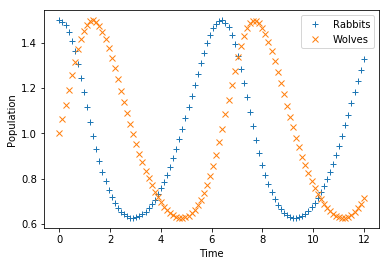

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the result
plt.plot(ts, prey, "+", label="Rabbits")
plt.plot(ts, predators, "x", label="Wolves")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend();

We can even look at a phase plane plot:

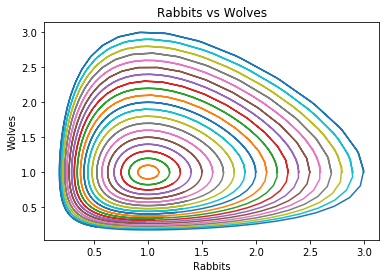

In [8]:
ic = np.linspace(1.0, 3.0, 21)
for r in ic:
    P0 = [r, 1.0]
    Ps = odeint(dP_dt, P0, ts)
    plt.plot(Ps[:,0], Ps[:,1], "-")
plt.xlabel("Rabbits")
plt.ylabel("Wolves")
plt.title("Rabbits vs Wolves");

## Fourier Transform

SciPy's `fftpack` module provides users with a performant way to compute discrete Fourier transforms (DFT).  Underneath the hood, `fftpack` is calling Fortran functions from the Fortran FFTPACK library.

Here's a brief example:

In [9]:
from scipy.fftpack import fft
import numpy

x = np.random.randint(10, size=5)
y = fft(x)
y

array([25.  +0.j        ,  2.5-10.04534985j,  2.5 +5.62058239j,
        2.5 -5.62058239j,  2.5+10.04534985j])

We can also compute the inverse:

In [10]:
from scipy.fftpack import ifft
yinv = ifft(y)
yinv

array([7.00000000e+00+0.j, 7.00000000e+00+0.j, 9.00000000e+00+0.j,
       7.10542736e-16+0.j, 2.00000000e+00+0.j])

In [11]:
x

array([7, 7, 9, 0, 2])

We won't go into the theory of Fourier transforms, but let us briefly mention what is involved in computing a DFT to highlight SciPy's performance.

Computing Fourier transforms reduces to a simple matrix multiplication; to compute the DFT for a vector $\displaystyle x$ we simply multiply it with the matrix $\displaystyle M$:

$\displaystyle M = e^{-2i\pi kn/N}$

We can use the matrix-vector operations we learned about in NumPy to write a naive implementation for computing DFT:

In [12]:
import numpy as np
def DFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

Let's double-check it works by comparing results with `fftpack`:

In [13]:
from scipy.fftpack import fft
x = np.random.random(1024)
np.allclose(DFT(x), fft(x))

True

Now let's look at the performance:

In [14]:
%timeit DFT(x)
%timeit fft(x)

104 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.9 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Linear Algebra

SciPy's `linalg` package greatly expands upon what we saw in NumPy.  There are a number of solvers available, including data interpolation modules, eigensolvers, and optimisation routines, but we'll only cover a few here.

Let us consider a system of linear equations, in matrix form:

$A x = b$

where $A$ is a matrix and $x,b$ are vectors.
Such system can be solved with SciPy like:

In [15]:
from scipy.linalg import *

In [16]:
A = np.array([[1,2],[3,4]])
b = np.array([3,17])

In [17]:
x = solve(A, b)

x

array([11., -4.])

In [18]:
# check
np.allclose(A @ x, b)

True

SciPy's `solve` function is faster than the built-in `inv` function:

In [19]:
A1 = np.random.random((1000,1000))
b1 = np.random.random(1000)
%timeit solve(A1, b1)

465 ms ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit inv(A1) @ b1

The slowest run took 5.46 times longer than the fastest. This could mean that an intermediate result is being cached.
237 ms ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can even import LAPACK functions for better performance:

In [21]:
import scipy.linalg.lapack as lapack

%timeit lu, piv, x, info = lapack.dgesv(A1, b1)

286 ms ± 75.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
